In [508]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

from nanonets import Simulation
from nanonets.utils import prepare_for_fitness_calculation, fitness, abundance, abundance_plot, get_best_logic_gate

plt.style.use(["science","bright"])
N_PARTICLES     = 9
N_ELECTRODES    = 8
ON_STATE        = 0.01
V_CONTROL       = 0.02
GATES           = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']

In [509]:
df              = pd.read_csv(f"Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df              = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"], on_state=ON_STATE)
df_fitness      = fitness(df, input_cols=["E1","E3"], on_state=ON_STATE)
df_abundance    = abundance(df_fitness)

In [510]:
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,-0.03043,0.00,-0.00769,0.00,0.00121,0.00239,-0.00728,0.0,0.0,100000.0,190000.0,-1.450436e+07,701464.599171
1,-0.03043,0.00,-0.00769,0.01,0.00121,0.00239,-0.00728,0.0,0.0,100000.0,556000.0,-5.405741e+06,267730.859093
2,-0.03043,0.01,-0.00769,0.00,0.00121,0.00239,-0.00728,0.0,0.0,100000.0,454000.0,-5.561546e+06,273546.616758
3,-0.03043,0.01,-0.00769,0.01,0.00121,0.00239,-0.00728,0.0,0.0,100000.0,10000000.0,-1.051264e+05,8687.928440
4,-0.03030,0.00,-0.01509,0.00,-0.01228,-0.00405,-0.00771,0.0,0.0,100000.0,126000.0,-1.999656e+07,940843.700860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,0.02871,0.01,0.01957,0.01,0.01452,-0.00684,-0.00528,0.0,0.0,100000.0,506000.0,8.887306e+06,438377.191151
676,0.03086,0.00,0.01586,0.00,-0.00612,-0.00463,0.00047,0.0,0.0,100000.0,352000.0,6.188729e+06,302114.210641
677,0.03086,0.00,0.01586,0.01,-0.00612,-0.00463,0.00047,0.0,0.0,100000.0,260000.0,1.048273e+07,519568.630876
678,0.03086,0.01,0.01586,0.00,-0.00612,-0.00463,0.00047,0.0,0.0,100000.0,290000.0,1.018865e+07,495204.535010


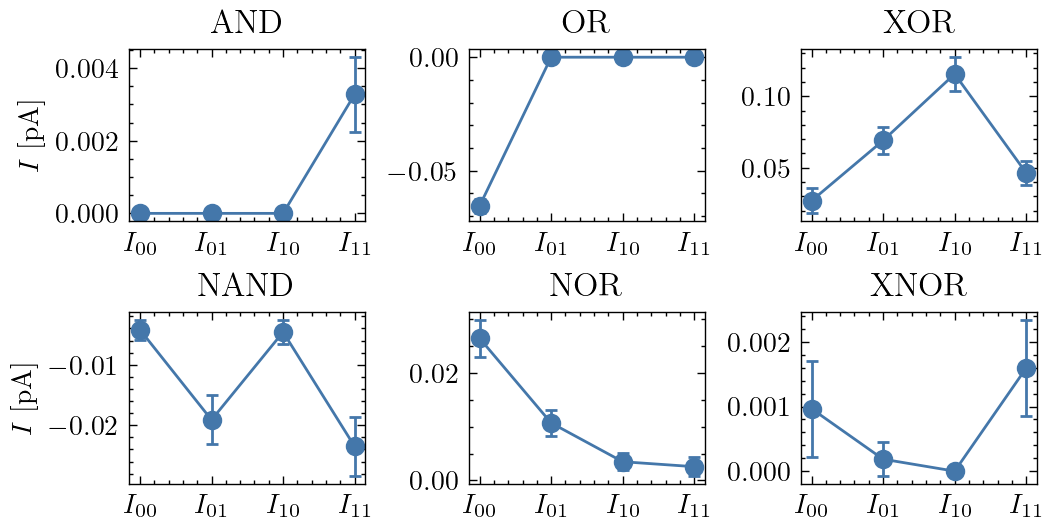

In [511]:
n   = 0
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(df, df_fitness, gate).sort_values(by=['E1','E3']).reset_index(drop=True)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_title(gate)
    if i % 3 == 0:
        ax.set_ylabel("$I$ [pA]")

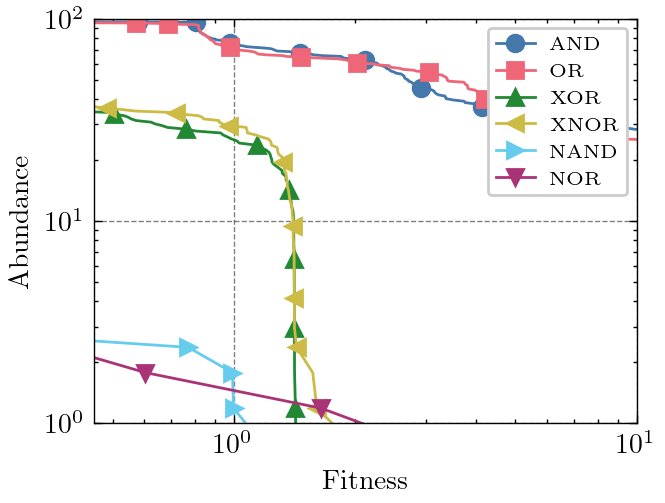

In [512]:
fig, ax = abundance_plot(df_abundance)#, x_limits=[0.1,10], y_limits=[0.1,100])

In [492]:
df_pot          = pd.read_csv(f"mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df_pot.columns  = [f'E{i}' for i in range(8)] + [i for i in range(N_PARTICLES**2)]
df_pot_best     = get_best_logic_gate(df_pot, df_fitness, 'OR').sort_values(by=['E1','E3']).reset_index(drop=True)
df_pot_best

,E0,E1,E2,E3,E4,E5,E6,E7,0,1,...,71,72,73,74,75,76,77,78,79,80
0,0.0081,0.00,-0.00882,0.00,-0.01314,0.00143,-0.00109,0.0,0.005417,0.003072,...,-0.001876,-0.010569,-0.007923,-0.005984,-0.004582,-0.002737,-0.002382,-0.002175,-0.002007,-0.001809
1,0.0081,0.00,-0.00882,0.01,-0.01314,0.00143,-0.00109,0.0,0.005601,0.003323,...,-0.000411,-0.008798,-0.005600,-0.003544,-0.002222,-0.000901,-0.000569,-0.000469,-0.000431,-0.000393
2,0.0081,0.01,-0.00882,0.00,-0.01314,0.00143,-0.00109,0.0,0.005448,0.003342,...,-0.000590,-0.010031,-0.007075,-0.005005,-0.003439,-0.001619,-0.001150,-0.000879,-0.000713,-0.000602
3,0.0081,0.01,-0.00882,0.01,-0.01314,0.00143,-0.00109,0.0,0.007029,0.004871,...,0.000763,-0.008471,-0.005074,-0.002944,-0.001430,-0.000270,0.000362,0.000650,0.000717,0.000700


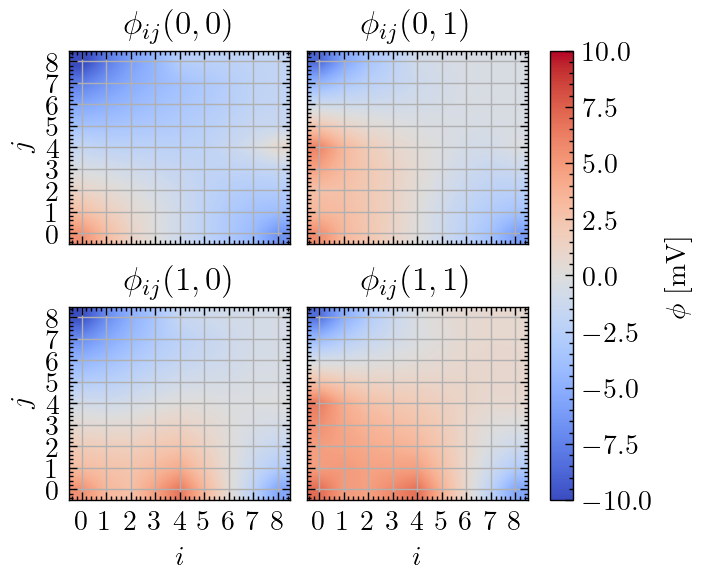

In [493]:
titles = ["$\phi_{ij}(0,0)$","$\phi_{ij}(0,1)$","$\phi_{ij}(1,0)$","$\phi_{ij}(1,1)$"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.1)
axs = []
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    im = ax.imshow(df_pot_best.iloc[i,8:].values.reshape(9,-9)*1000, cmap='coolwarm',
              vmin=-1000*ON_STATE, vmax=1000*ON_STATE, interpolation='bilinear', aspect='auto')
    ax.invert_yaxis()
    ax.set_title(titles[i])
    ax.grid()
    if i % 2 == 0:
        ax.set_yticks(np.arange(N_PARTICLES))
        ax.set_ylabel("$j$")
    else:
        ax.set_yticks(np.arange(N_PARTICLES))
        ax.set_yticklabels("")
    if i >= 2:
        ax.set_xticks(np.arange(N_PARTICLES))
        ax.set_xlabel("$i$")
    else:
        ax.set_xticks(np.arange(N_PARTICLES))
        ax.set_xticklabels("")
    axs.append(ax)
cb = fig.colorbar(im, ax=axs, shrink=1.0, label="$\phi$ [mV]")

---

In [494]:
topo = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
        "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                    [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                    [N_PARTICLES-1,int((N_PARTICLES)/2)],
                    [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
        "electrode_type" : ['constant']*N_ELECTRODES}
sim_class   = Simulation(topo, pack_optimizer=False)
inv_cap     = sim_class.get_inv_capacitance_matrix()
e_cap       = sim_class.get_electrode_capacitance_matrix().T
Alpha       = (-inv_cap @ e_cap).T
C_ii_inv    = inv_cap.diagonal()
E_ii        = (C_ii_inv*sim_class.ELE_CHARGE_A_C**2)/2
V_ii        = 1000 * E_ii / sim_class.ELE_CHARGE_A_C
E_ii_min    = np.min(E_ii)
V_ii_min    = E_ii_min / sim_class.ELE_CHARGE_A_C

print(f"Charging Energy:\n{E_ii}")
print(f"Minimum Energy:\n{E_ii_min}")
print(f"Minimum Voltage:\n{V_ii_min}")

Charging Energy:
[0.0003931  0.0003666  0.00034988 0.00033781 0.00032368 0.00033781
 0.00034988 0.0003666  0.0003931  0.00036234 0.00032257 0.00030732
 0.00029927 0.00029649 0.00029927 0.00030732 0.00032257 0.00036234
 0.000348   0.00030683 0.00029166 0.00028425 0.00028196 0.00028425
 0.00029166 0.00030683 0.000348   0.00033666 0.00029877 0.00028409
 0.0002769  0.0002747  0.0002769  0.00028409 0.00029877 0.00033666
 0.00032276 0.00029601 0.00028176 0.00027465 0.00027247 0.00027465
 0.00028176 0.00029601 0.00032276 0.00033666 0.00029877 0.00028409
 0.0002769  0.0002747  0.0002769  0.00028409 0.00029877 0.00033666
 0.000348   0.00030683 0.00029166 0.00028425 0.00028196 0.00028425
 0.00029166 0.00030683 0.000348   0.00036234 0.00032257 0.00030732
 0.00029927 0.00029649 0.00029927 0.00030732 0.00032257 0.00036234
 0.0003931  0.0003666  0.00034988 0.00033781 0.00032368 0.00033781
 0.00034988 0.0003666  0.0003931 ]
Minimum Energy:
0.0002724681824636792
Minimum Voltage:
0.0017006126482090294


(0.0, 1.5)

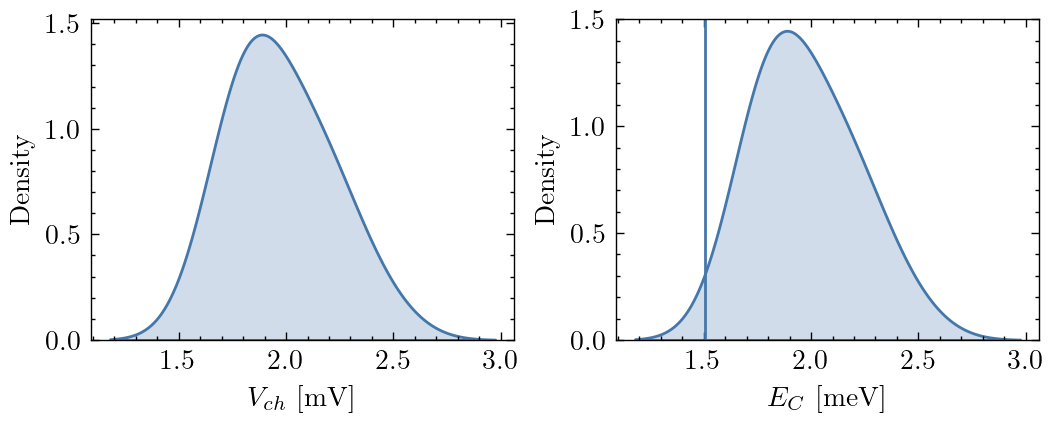

In [495]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot(1,2,1)
ax  = sns.kdeplot(1000 * E_ii / sim_class.ELE_CHARGE_A_C, fill=True, bw_adjust=2)
_   = ax.set_xlabel("$V_{ch}$ [mV]")

ax  = fig.add_subplot(1,2,2)
ax  = sns.kdeplot(1000*6.2415090745*E_ii, fill=True, bw_adjust=2)
_   = ax.set_xlabel("$E_{C}$ [meV]")
ax.vlines(x=3.5*1000*sim_class.KB_EV_PER_K*5, ymin=0, ymax=1.5)
ax.set_ylim(0,1.5)

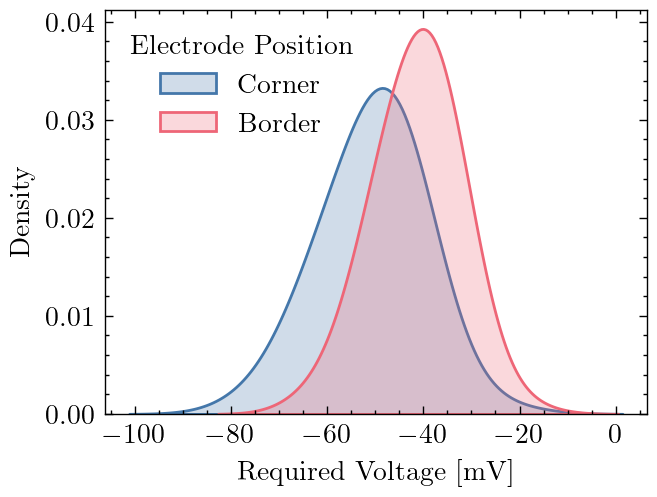

In [486]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(V_ii / Alpha[0,:], fill=True, bw_adjust=2, label='Corner')
ax  = sns.kdeplot(V_ii / Alpha[1,:], fill=True, bw_adjust=2, label='Border')
_   = ax.set_xlabel("Required Voltage [mV]")
_   = ax.legend(loc='upper left', title='Electrode Position')

In [6]:
df = pd.read_csv(f"Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,0.00048,0.000,-0.00500,0.000,-0.00553,0.00930,-0.00081,0.0,0.0,100000.0,474000.0,5.212724e+06,256189.817494
1,0.00553,0.002,0.00039,0.000,-0.00368,0.00904,0.00340,0.0,0.0,100000.0,194000.0,1.086384e+07,522250.189514
2,-0.00813,0.000,-0.00776,0.000,0.00757,0.00031,0.00575,0.0,0.0,100000.0,1594000.0,2.333168e+06,116226.781801
3,-0.00383,0.002,0.00592,0.000,-0.00114,0.00725,0.00651,0.0,0.0,100000.0,116000.0,1.362024e+07,661828.343808
4,0.00364,0.000,0.00708,0.000,-0.00107,0.00928,0.00645,0.0,0.0,100000.0,78000.0,1.911141e+07,918893.328313
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,-0.00199,0.002,0.00155,0.002,-0.00347,-0.00882,0.00899,0.0,0.0,100000.0,10000000.0,-1.936522e+04,47774.672476
9226,0.00237,0.000,-0.00529,0.002,0.00535,-0.00793,0.00270,0.0,0.0,100000.0,1256000.0,-2.781021e+06,138441.724616
9227,-0.00409,0.002,-0.00193,0.002,-0.00762,-0.00665,0.00206,0.0,0.0,100000.0,746000.0,-3.068565e+06,152709.791291
9228,0.00506,0.000,0.00877,0.002,0.00264,0.00092,-0.00759,0.0,0.0,100000.0,1140000.0,-3.052228e+06,151710.890804


ValueError: 'x' and 'y' must have the same size

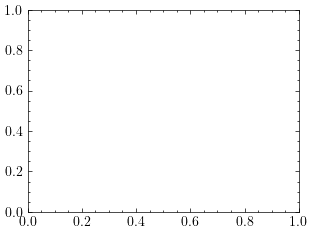

In [7]:
plt.errorbar(range(170), df['Observable'].values*1e-9, df['Error'].values*1e-9)

In [ ]:
values_AND_9    = [0.085337,0.00,-0.03929,0.00,-0.022938,0.010342,0.002624,0.0,0.0]
values_AND_11   = [0.017308,0.00,0.070893,0.00,0.073702,0.038,0.030185,0.0,0.0]
values_AND_13   = [0.089993,0.00,0.063558,0.00,-0.048817,0.011171,0.037835,0.0,0.0]

values_XOR_9    = [-0.094029,0.00,0.051392,0.00,0.03737,-0.040439,-0.043346,0.0,0.0]
values_XOR_11   = [-0.044536,0.00,0.066428,0.00,0.096061,-0.021845,-0.081427,0.0,0.0]
values_XOR_13   = [-0.070379,0.00,0.091417,0.00,0.08231,-0.015387,-0.013483,0.0,0.0]

voltages        = np.tile(np.round(values_AND_13,4), (4,1))
voltages[:,1]   = [0.0,0.0,0.01,0.01]
voltages[:,3]   = [0.0,0.01,0.0,0.01]
voltages

array([[ 0.09  ,  0.    ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.    ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ]])

In [ ]:
N_p                 = 13
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0], [int((N_p-1)/2),0,0], [N_p-1,0,0], 
                            [0,int((N_p-1)/2),0], [0,N_p-1,0], [N_p-1,int((N_p)/2),0],
                            [int((N_p)/2),(N_p-1),0], [N_p-1,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                           'constant','constant','constant','floating']
}
target_electrode    = len(topology_parameter["e_pos"])-1
sim_dic             =   {
    "error_th"        : 0.05,
    "max_jumps"       : 10000000,
    "eq_steps"        : 100000,
    "jumps_per_batch" : 1000,
    "kmc_counting"    : False,
    "min_batches"     : 5
}
# sim_dic             =   {
#     "error_th"        : 0.0,
#     "max_jumps"       : 100000,
#     "eq_steps"        : 100000,
#     "jumps_per_batch" : 1,
#     "kmc_counting"    : False,
#     "min_batches"     : 0
# }

In [ ]:
list_results        = []
# target_observables  = []
for i in range(10):
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, sim_dic=sim_dic, verbose=False)
    results     = sim_class.return_output_values()
    states      = sim_class.return_potential_landscape()*1000
    net_curr    = pd.DataFrame(sim_class.return_network_currents()[1], columns=sim_class.return_network_currents()[0])
    list_results.append(results)
    # target_observables.append(sim_class.target_observable_values[0]*1000)

In [ ]:
# plt.figure(dpi=200)
# for target_observable in target_observables:
#     plt.plot(target_observable)
#     plt.xlim(0,2000)

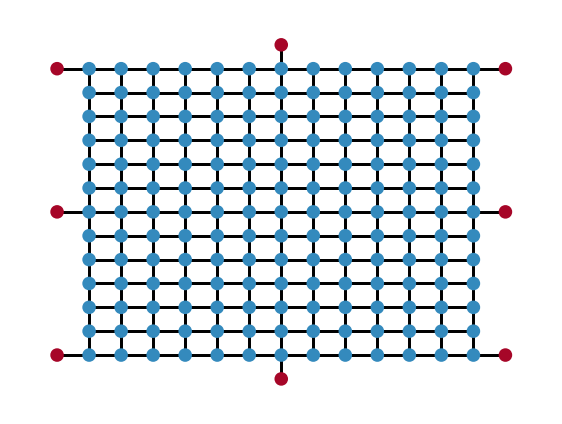

In [ ]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
fig, ax = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=15)

Text(0, 0.5, '$U$ [mV]')

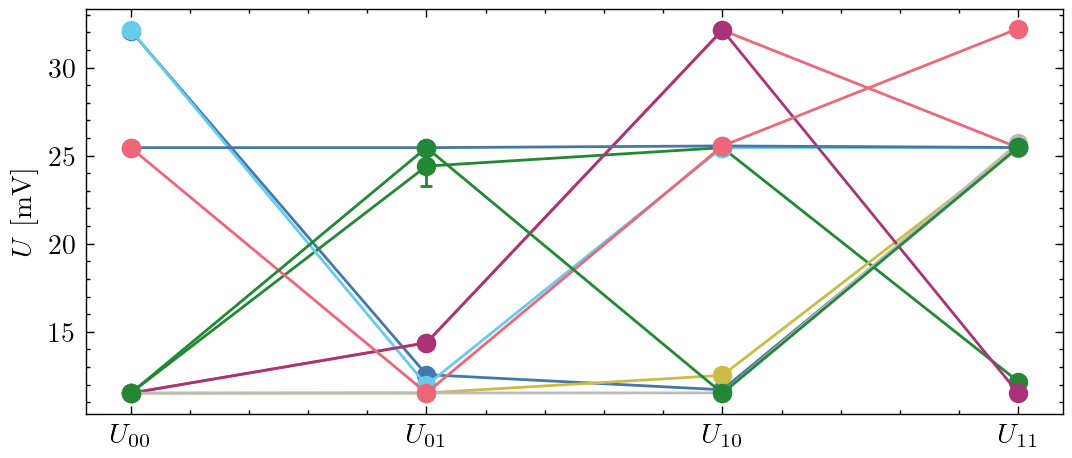

In [ ]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot()
for results in list_results:
    ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"],
                results[:,2]*1000, results[:,3]*1000, marker='o', capsize=2)
ax.set_ylabel("$U$ [mV]")

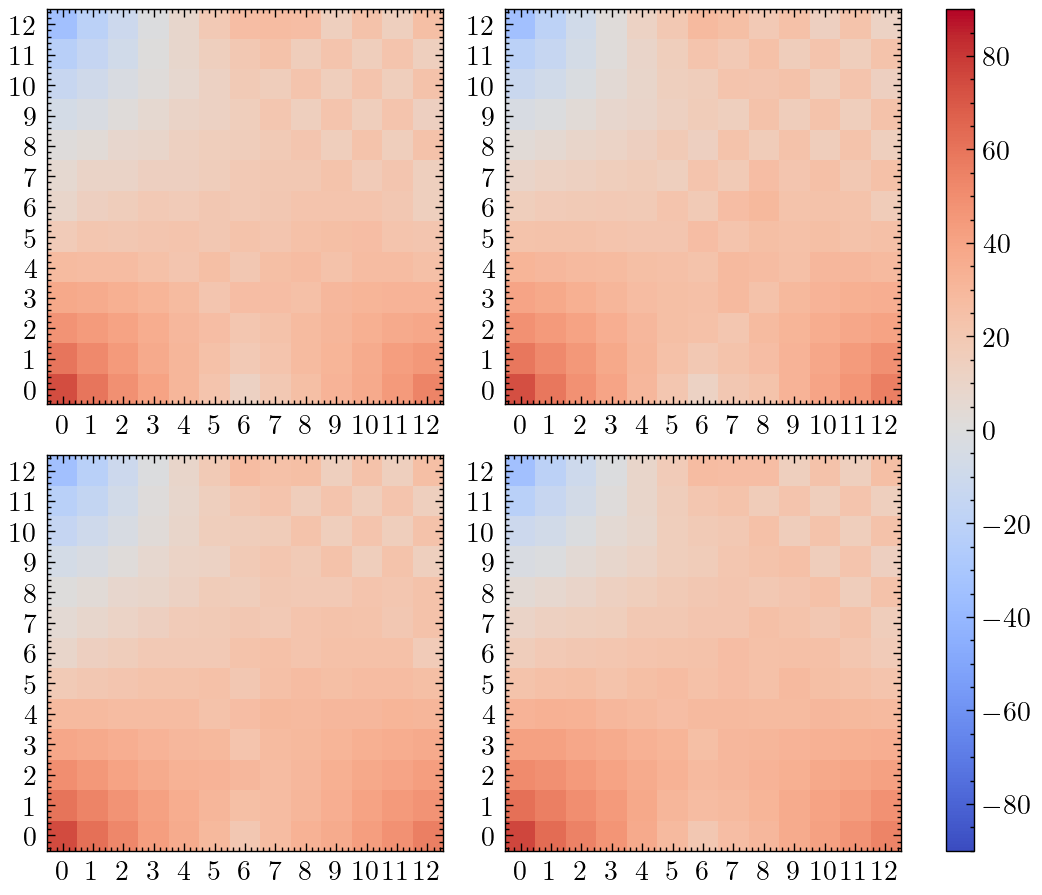

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.7)
fig.set_figwidth(fig.get_figwidth()*1.5)

vmin = -np.max(np.abs(states))
vmax = np.max(np.abs(states))

# Create subplots and add imshow plots
axes = []
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    im = ax.imshow(states[i, 8:].reshape(N_p, -1), cmap='coolwarm', interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(N_p))
    ax.set_yticks(np.arange(N_p))
    ax.invert_yaxis()
    axes.append(ax)

# Add a figure-level colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=1.0, label="", aspect=30)

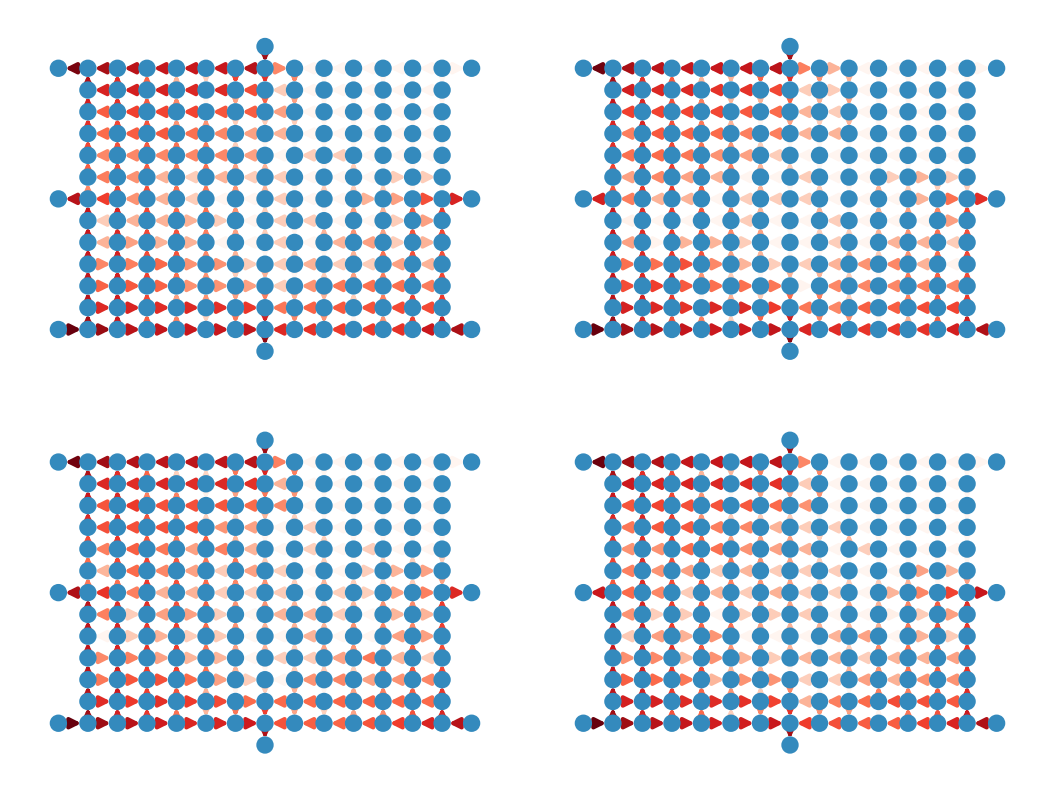

In [ ]:
fig = plt.figure(dpi=300, layout='constrained')

for row in range(4):

    ax      = fig.add_subplot(2,2,row+1)
    fig, ax = nanonets_utils.display_network_currents(df=net_curr, row=row, N_electrodes=8, pos=sim_class.pos,
                                                    fig=fig, ax=ax, node_size=10, arrowsize=5)


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(net_curr.columns)

last_node   = np.max(G.edges)
distances   = [nx.shortest_path_length(G=G, source=i, target=last_node) for i in range(N_p*N_p)]
states_mean = np.mean(states,axis=0)[8:]

In [ ]:
state_df = pd.DataFrame([distances,states_mean]).T
state_df

,0,1
0,25.0,73.962427
1,19.0,60.593892
2,13.0,51.121223
3,19.0,42.282099
4,13.0,33.433444
...,...,...
164,12.0,24.065276
165,11.0,16.947411
166,10.0,21.058220
167,9.0,16.436487


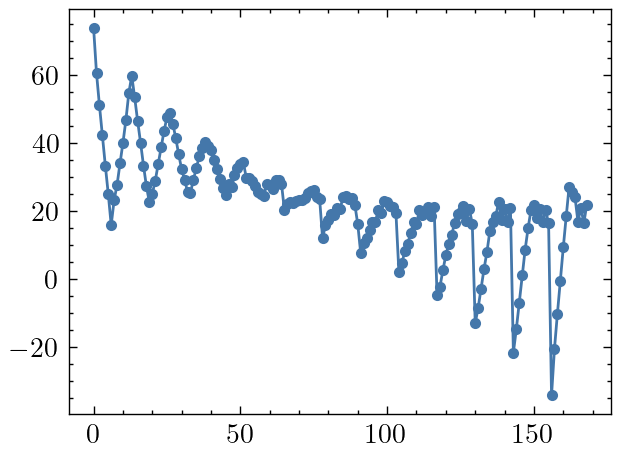

In [ ]:
plt.figure(dpi=200)
plt.plot(states_mean, '.-')

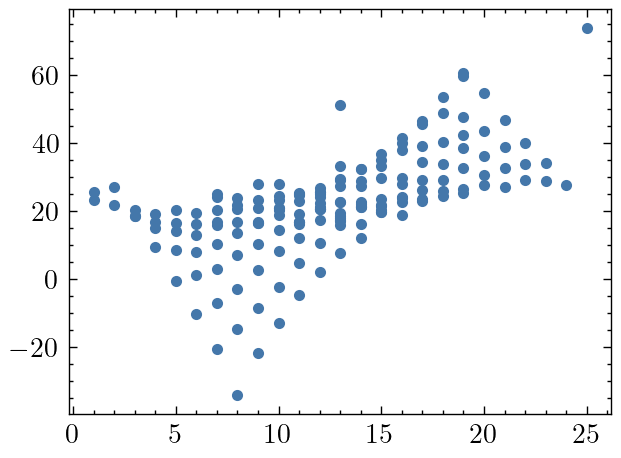

In [ ]:
plt.figure(dpi=200)
plt.plot(distances, np.mean(states,axis=0)[8:], '.')

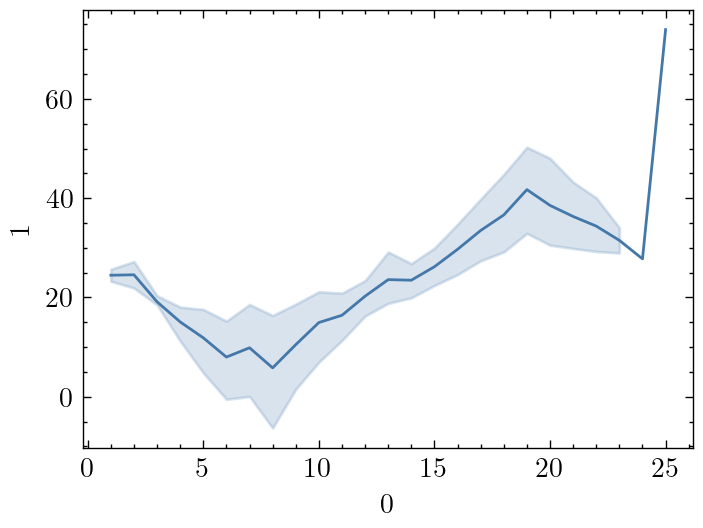

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.lineplot(data=state_df, x=0, y=1, ax=ax, markers=True)